## Task 2: Job posting ingestion pipeline


### CoNVO

**Context:** Bloc is a career services management platform that builds smart career and data management tools for job-seekers and the organizations serving them. In particular, Bloc seeks to provide and facilitate access to tools for effectively presenting job-seekers' credentials and matching employers' job postings, and thereby improve outcomes.

**Need:** Job-seekers need help finding job postings that are aligned with their skills, goals, salary, and location (among other constraints), since that helps to reduce time spent filtering out bad matches and improve the likelihood of a successful outcome. Typical "fuzzy search" by job title, maybe with structured filters layered on top, performs decently well, but does take time. Unfortunately, an outside consumer of job postings like Bloc generally has more restricted options in terms of a jobs search.

**Vision:** Automated extraction of key information from job postings, and perhaps classification of postings into relevant categories, pulled from external data sources, in order to better match job postings with job-seekers.

**Outcome:** A standalone, proof-of-concept process for extracting key job posting information (and categorizing it into relevant classes), and returning it as structured data, complete with unit tests and documentation on expected usage, limitations, and potential improvements.


### Data Summary

A collection of ~4800 job postings for tech+data roles in several major U.S. cities have been fetched from the following external APIs:

- [GitHub Jobs API](https://jobs.github.com/api)
- [Indeed.com API](https://opensource.indeedeng.io/api-documentation/)
- [TheMuse.com API](https://www.themuse.com/developers/api/v2)

The APIs all return JSON-formatted data, but with a variety of fields and level of detail. All jobs include structured data for the job title, location, company, and URL, as well as a field containing either all or a short snippet of the job description as text data. These descriptions generally contain information on required / desired applicant qualifications, expected responsibilities and tasks, company missions and benefits, and more -- but snippets don't consistently contain the most important details.


### Proposed Methodology

The first and simplest task is to transform the structured data from each of the data sources into a consistent representation; in practice, this will entail renaming fields and parsing values (e.g. dates) into a standardized form. The second task is to extract as much relevant information from the free text job descriptions as possible -- key skills, technological expertise, education requirements, etc. -- in a form that allows for matching against job-seekers' skills, expertise, education. A combination of regular expressions, fuzzy string matching, and dictionary/gazetteer lookups, and other basic text processing will hopefully be enough to reliably extract info. The final, possibly optional task is to train text categorizers to predict classes of interest based on the descriptions' text: company culture? flexibility of work-life balance? Given the small size of the dataset, a simple bag-of-words-based approach may be more likely to succeed than, say, a deep learning model.


### Definitions of Success

- **Baseline:** A function that accepts a job posting from any of the three listed data sources and returns standardized, structured data for key job metadata (title, location, company, and posting URL), plus any available information on skills/expertise/education required or desired for the role. The quality of the extracted values may be messy or not fully structured, but shouldn't contain values from other fields. This function should have basic unit tests and documentation.
- **Target:** A function that accepts a job posting from any of the three listed data sources and returns standardized, structured data for key job metadata and available information on required/desired job qualifications (see Baseline), plus any available information on expected responsibilities and company mission/benefits. The quality of the extracted values should be mostly structured -- not large blobs of text, just the most informative bits -- and shouldn't contain values from other fields. This function should have unit tests covering a variety of expected scenarios and good documentation.
- **Stretch:** A function as described in Target, plus trained text categorization models for predicting one or more classes of interest. Text preprocessing and model structure must be documented, as well as validation results for model performance.


### Risks

It's possible that the information included in / extracted from job postings is too complex or varied for sufficiently accurate rules-based parsing, in which case a more sophisticated (ML- or DL-based) approach would be necessary, albeit impractical owing to time and data constraints. It's also possible that a rules-based approach is feasible, but too difficult / large a task for a single day's work.

Similarly, job categories that Bloc would find most useful may not be feasible given the size and limitations of the available training dataset. The challenge here is finding categorizations that are still useful but not too abstract/complex for a machine to learn with sufficient accuracy in a single day's work.

## Source Code

In [1]:
%load_ext watermark

### Dataset Generation

**Note:** Don't run this section! This is just to help you understand the data's provenance. Instead, download the already-generated datasets from OneDrive. (There's a link on the Bloc Project Home document in Dropbox.)

In [2]:
import io
import itertools
import json
import pathlib

import requests

In [3]:
import sys
sys.path.insert(0, '/Users/matthewcassi/Documents/msvdd_Bloc-master')
import msvdd_bloc

In [4]:
import job_cleanup_functions as jcf

In [5]:
%watermark -v -iv

requests 2.21.0
json     2.0.9
CPython 3.7.3
IPython 7.4.0


In [19]:
data_dir = pathlib.Path("/Users/matthewcassi/Documents/msvdd_Bloc-master/msvdd_Bloc/data/postings")
role_queries = [
    "web developer",
    "front-end developer",
    "back-end developer",
    "full-stack developer",
    "python",
    "data scientist",
    "data engineer",
]
category_queries = ["Engineering", "Data Science"]
locations = [
    "New York, NY",
    "Chicago, IL",
    "San Francisco, CA",
    "San Jose, CA",
    "Los Angeles, CA",
    "Seattle, WA",
    "Austin, TX",
    "Washington, DC",
    "Baltimore, MD",
    "Boston, MA",
]

#### GitHub Jobs API

In [20]:
all_search_results = []
for query, location in itertools.product(role_queries, locations):
    print("(query, location) =>", (query, location))
    try:
        results = msvdd_bloc.data.postings.fetch_from_github(query=query, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

github_jobs = msvdd_bloc.data.utils.dedupe_results(all_search_results, "id")
print("# jobs fetched =", len(github_jobs))
github_jobs[:1]

(query, location) => ('web developer', 'New York, NY')
(query, location) => ('web developer', 'Chicago, IL')
(query, location) => ('web developer', 'San Francisco, CA')
(query, location) => ('web developer', 'San Jose, CA')
(query, location) => ('web developer', 'Los Angeles, CA')
(query, location) => ('web developer', 'Seattle, WA')
(query, location) => ('web developer', 'Austin, TX')
(query, location) => ('web developer', 'Washington, DC')
(query, location) => ('web developer', 'Baltimore, MD')
(query, location) => ('web developer', 'Boston, MA')
(query, location) => ('front-end developer', 'New York, NY')
(query, location) => ('front-end developer', 'Chicago, IL')
(query, location) => ('front-end developer', 'San Francisco, CA')
(query, location) => ('front-end developer', 'San Jose, CA')
(query, location) => ('front-end developer', 'Los Angeles, CA')
(query, location) => ('front-end developer', 'Seattle, WA')
(query, location) => ('front-end developer', 'Austin, TX')
(query, locati

[{'id': '3e378b91-7cc0-486e-b18d-518ab29569e3',
  'type': 'Full Time',
  'url': 'https://jobs.github.com/positions/3e378b91-7cc0-486e-b18d-518ab29569e3',
  'created_at': 'Wed Sep 11 18:59:59 UTC 2019',
  'company': 'Simon & Schuster ',
  'company_url': 'https://www.simonandschuster.com/',
  'location': 'New York, NY',
  'title': 'Lead Software Engineer',
  'description': '<p>Simon &amp; Schuster is seeking a Lead Software Engineer to join a rapidly growing team focused on impacting the world of publishing through research and innovation. Working with a team of data scientists, data engineers, designers, and domain experts, you will be involved in rapidly prototyping, developing, and deploying the platforms that put insights and information into the hands of decision-makers.</p>\n<p>From databases to serverless applications, you will be designing, deploying , and managing the systems that connect our real-world data to the books and authors that inform and entertain our world. As a Full

In [24]:
msvdd_bloc.data.fileio.save_json(github_jobs, data_dir.joinpath("github_jobs.json"))

TypeError: expected str, bytes or os.PathLike object, not list

#### Indeed.com API

In [22]:
# this is, effectively, an API key -- i borrowed it from Bloc
with io.open("/Users/matthewcassi/Documents/msvdd_Bloc-master/indeed", mode="rt") as f:
    publisher_id = f.read().strip()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/burtondewilde/.bloc/indeed'

In [11]:
user_ip = requests.get("https://api.ipify.org").text

In [12]:
all_search_results = []
for query, location in itertools.product(role_queries, locations):
    print("(query, location) =>", (query, location))
    try:
        results = msvdd_bloc.data.postings.fetch_from_indeed(publisher_id, user_ip, query=query, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

indeed_jobs = msvdd_bloc.data.utils.dedupe_results(all_search_results, "jobkey")
print("# jobs fetched =", len(indeed_jobs))
indeed_jobs[:1]

(query, location) => ('web developer', 'New York, NY')
(query, location) => ('web developer', 'Chicago, IL')
(query, location) => ('web developer', 'San Francisco, CA')
(query, location) => ('web developer', 'San Jose, CA')
(query, location) => ('web developer', 'Los Angeles, CA')
(query, location) => ('web developer', 'Seattle, WA')
(query, location) => ('web developer', 'Austin, TX')
(query, location) => ('web developer', 'Washington, DC')
(query, location) => ('web developer', 'Baltimore, MD')
(query, location) => ('web developer', 'Boston, MA')
(query, location) => ('front-end developer', 'New York, NY')
(query, location) => ('front-end developer', 'Chicago, IL')
(query, location) => ('front-end developer', 'San Francisco, CA')
(query, location) => ('front-end developer', 'San Jose, CA')
(query, location) => ('front-end developer', 'Los Angeles, CA')
(query, location) => ('front-end developer', 'Seattle, WA')
(query, location) => ('front-end developer', 'Austin, TX')
(query, locati

[{'jobtitle': 'Junior Developer',
  'company': 'Muratek',
  'city': 'New York',
  'state': 'NY',
  'country': 'US',
  'language': 'en',
  'formattedLocation': 'New York, NY',
  'source': 'Indeed',
  'date': 'Fri, 20 Sep 2019 16:25:56 GMT',
  'snippet': 'Develop and maintain code, image assets and content for multiple company and client projects. Manage multiple projects and execute design from concept to launch. We are IT Networking Consultants that work with a wide array of clientele. Linux command line....',
  'url': 'http://www.indeed.com/rc/clk?jk=f8026d3d2654ebbf&atk=',
  'onmousedown': "indeed_clk(this,'');",
  'latitude': 40.70609,
  'longitude': -74.00445,
  'jobkey': 'f8026d3d2654ebbf',
  'sponsored': False,
  'expired': False,
  'indeedApply': True,
  'formattedLocationFull': 'New York, NY 10038',
  'formattedRelativeTime': '12 days ago',
  'stations': '',
  'recommendations': []}]

In [14]:
msvdd_bloc.data.fileio.save_json(indeed_jobs, data_dir.joinpath("indeed_jobs.json"))

#### The Muse API

In [16]:
all_search_results = []    
for category, location in itertools.product(category_queries, locations):
    print("(category, location) =>", (category, location))
    try:
        results = msvdd_bloc.data.postings.fetch_from_themuse(category=category, location=location, limit=100)
        all_search_results.extend(results)
    except Exception:
        break

themuse_jobs = msvdd_bloc.data.utils.dedupe_results(all_search_results, "id")
print("# jobs fetched =", len(themuse_jobs))
themuse_jobs[:1]

(category, location) => ('Engineering', 'New York, NY')
(category, location) => ('Engineering', 'Chicago, IL')
(category, location) => ('Engineering', 'San Francisco, CA')
(category, location) => ('Engineering', 'San Jose, CA')
(category, location) => ('Engineering', 'Los Angeles, CA')
(category, location) => ('Engineering', 'Seattle, WA')
(category, location) => ('Engineering', 'Austin, TX')
(category, location) => ('Engineering', 'Washington, DC')
(category, location) => ('Engineering', 'Baltimore, MD')
(category, location) => ('Engineering', 'Boston, MA')
(category, location) => ('Data Science', 'New York, NY')
(category, location) => ('Data Science', 'Chicago, IL')
(category, location) => ('Data Science', 'San Francisco, CA')
(category, location) => ('Data Science', 'San Jose, CA')
(category, location) => ('Data Science', 'Los Angeles, CA')
(category, location) => ('Data Science', 'Seattle, WA')
(category, location) => ('Data Science', 'Austin, TX')
(category, location) => ('Data S

[{'contents': '<p><span>Language diverse monorepo seeks experienced wrangler to help its engineers thrive.</span></p>\n\n<p><span>We\'re growing our team rapidly and want to invest in the infrastructure our engineers need to be productive. That\'s where you come in. There\'s a lot to do with immediate impact and your customers are the engineers sitting right by you.\xa0</span></p>\n\n<p><span>Beeswax is an easy to use, massive scale and high availability advertising platform founded by industry veterans who worked together at Google. We’re well funded by leading VCs, such as RRE and Foundry Group, and are rapidly expanding our customer list and our engineering team. We offer our customers the most extensible and transparent advertising system in the world and process millions of transactions per second.\xa0</span></p>\n\n<p><span>Our engineers come from major tech companies such as Amazon and Facebook as well as many other companies with strong software disciplines. Building and sellin

In [17]:
msvdd_bloc.data.fileio.save_json(themuse_jobs, data_dir.joinpath("themuse_jobs.json"))

#### combined dataset

(assuming no duplicates across sources)

In [18]:
print("total # of jobs fetched = ", len(github_jobs + indeed_jobs + themuse_jobs))

total # of jobs fetched =  4822


### Getting Started

In [6]:
import os
import re

import en_core_web_md
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import spacy
import textacy
import nltk

In [7]:
%matplotlib inline

In [8]:
%watermark -v -iv

nltk           3.4
spacy          2.0.12
pandas         0.24.2
re             2.2.1
matplotlib     3.0.3
requests       2.21.0
json           2.0.9
en_core_web_md 2.1.0
missingno      0.4.2
textacy        0.8.0
CPython 3.7.3
IPython 7.4.0


#### load / inspect data

In [9]:
def load_dataset(filepath, **kwargs):
    """
    Args:
        filepath (str)
        kwargs: Additional params passed as-is
            into :func:`pd.read_json()`, useful for setting
            dataset-specific dtypes, etc.
    
    Returns:
        :class:`pd.DataFrame`
    """
    # almost too easy ;)
    return pd.read_json(path_or_buf=filepath, **kwargs)


def inspect_dataset(dataset):
    """
    Args:
        dataset (:class:`pd.DataFrame`)
    """
    print("shape:", dataset.shape)
    print("columns:", ", ".join(dataset.columns))
    return dataset.describe(include="all")

In [10]:
data_dir = "/Users/matthewcassi/Documents/msvdd_Bloc-master/data/"

In [11]:
df_github = load_dataset(os.path.join(data_dir, "github_jobs.json"))
inspect_dataset(df_github)

shape: (67, 11)
columns: company, company_logo, company_url, created_at, description, how_to_apply, id, location, title, type, url


,company,company_logo,company_url,created_at,description,how_to_apply,id,location,title,type,url
count,67,50,58,67,67,67,67,67,67,67,67
unique,58,50,53,67,67,64,67,46,60,1,67
top,"Thorlabs, Inc.",https://jobs.github.com/rails/active_storage/b...,https://www.sailpoint.com/,2018-11-09 16:54:38,<p>DESCRIPTION:</p>\n<p>Allego is seeking a se...,"<p><a href=""https://www.acadian-asset.com/care...",d2cad153-5c5b-43e0-bef6-60005bd5174f,"New York, NY",Full Stack Developer,Full Time,https://jobs.github.com/positions/c65408fa-de1...
freq,3,1,3,1,1,2,1,5,3,67,1
first,NaN,NaN,NaN,2018-10-22 15:56:13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-10-01 15:50:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# what's the average length (in chars) of job descriptions?
df_github["description"].str.len().describe()

count       67.000000
mean      3629.955224
std       1770.982696
min          1.000000
25%       2628.000000
50%       3165.000000
75%       4322.500000
max      10467.000000
Name: description, dtype: float64

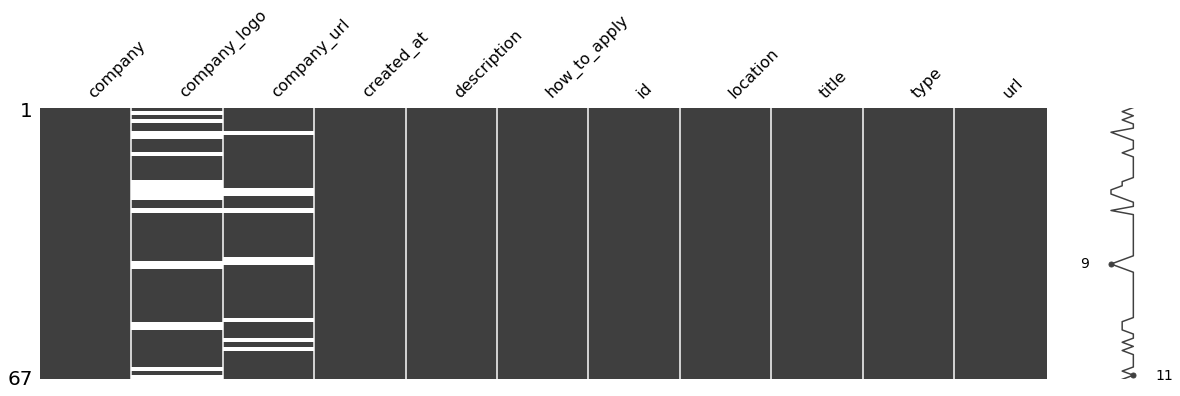

In [13]:
_ = msno.matrix(df_github, figsize=(20, 5))

In [14]:
df_indeed = load_dataset(os.path.join(data_dir, "indeed_jobs.json"))
inspect_dataset(df_indeed)

shape: (4187, 22)
columns: city, company, country, date, expired, formattedLocation, formattedLocationFull, formattedRelativeTime, indeedApply, jobkey, jobtitle, language, latitude, longitude, onmousedown, recommendations, snippet, source, sponsored, state, stations, url


,city,company,country,date,expired,formattedLocation,formattedLocationFull,formattedRelativeTime,indeedApply,jobkey,...,latitude,longitude,onmousedown,recommendations,snippet,source,sponsored,state,stations,url
count,4187,4187,4187,4187,4187,4187,4187,4187,4187,4187,...,4187.000000,4187.000000,4187,4187,4187,4187,4187,4187,4187,4187
unique,185,2511,1,3885,1,185,519,56,2,4187,...,NaN,NaN,1,1,3912,1836,1,9,1,4187
top,New York,"Amazon.com Services, Inc.",US,2019-07-24 20:17:25,False,"New York, NY","New York, NY",30+ days ago,True,951153b4b5c2d5e0,...,NaN,NaN,"indeed_clk(this,'');",[],"We’ll help you develop the career you want, as...",Indeed,False,CA,,http://www.indeed.com/rc/clk?jk=bf6089fc371454...
freq,431,81,4187,7,4187,431,236,1805,2137,1,...,NaN,NaN,4187,4187,7,809,4187,1215,4187,1
first,NaN,NaN,NaN,2019-06-04 14:22:33,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2019-10-03 01:24:54,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.075605,-96.257744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.420494,21.070579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.118260,-122.712456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,37.384247,-121.955240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# what's the average length (in chars) of job descriptions?
df_indeed["snippet"].str.len().describe()

count    4187.000000
mean      374.636016
std        44.626553
min        85.000000
25%       366.000000
50%       395.000000
75%       401.000000
max       423.000000
Name: snippet, dtype: float64

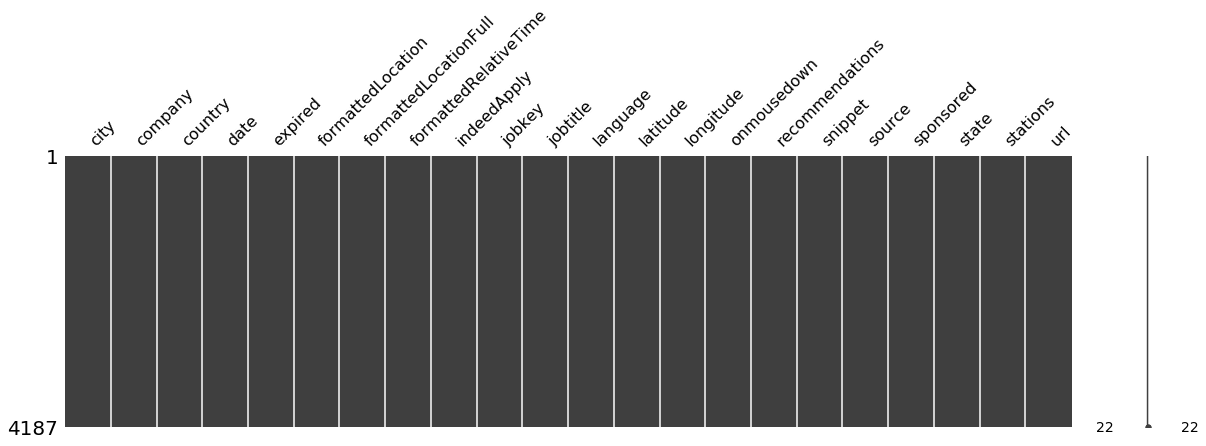

In [16]:
_ = msno.matrix(df_indeed, figsize=(20, 5))

In [17]:
df_themuse = load_dataset(os.path.join(data_dir, "themuse_jobs.json"))
inspect_dataset(df_themuse)

shape: (568, 13)
columns: categories, company, contents, id, levels, locations, model_type, name, publication_date, refs, short_name, tags, type


,categories,company,contents,id,levels,locations,model_type,name,publication_date,refs,short_name,tags,type
count,568,568,568,5.680000e+02,568,568,568,568,568,568,568,568,568
unique,9,80,537,NaN,8,34,1,472,568,568,546,3,2
top,[{'name': 'Engineering'}],"{'id': 792, 'short_name': 'northropgrumman', '...",<p>Join a team that has been partnering with o...,NaN,[],"[{'name': 'New York, NY'}]",jobs,Summer/Intern Student,2018-12-20T20:25:02.754411Z,{'landing_page': 'https://www.themuse.com/jobs...,senior-software-engineer,[],external
freq,525,82,16,NaN,231,90,568,16,1,1,5,439,561
mean,NaN,NaN,NaN,1.901373e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,3.970222e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,3.074000e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,1.774684e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,2.063980e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,2.175266e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# what's the average length (in chars) of job descriptions?
df_themuse["contents"].str.len().describe()

count     568.000000
mean     3960.153169
std      1301.442606
min       275.000000
25%      3046.000000
50%      3915.500000
75%      4834.250000
max      9961.000000
Name: contents, dtype: float64

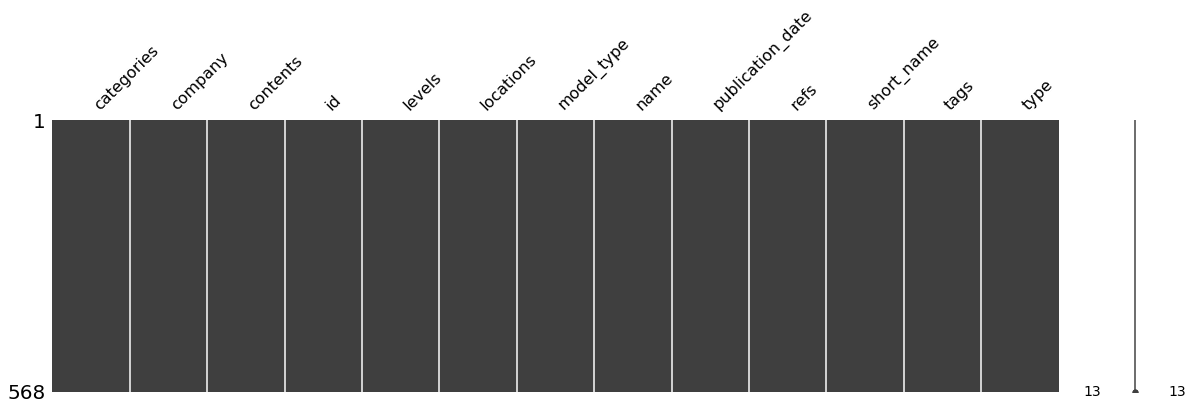

In [19]:
_ = msno.matrix(df_themuse, figsize=(20, 5))

#### munge data

In [20]:
from html.parser import HTMLParser


class _HTMLParser(HTMLParser):
    
    def __init__(self):
        super().__init__()
        self._texts = []
    
    def handle_data(self, data):
        self._texts.append(data)
        
    def get_text(self):
        return "".join(self._texts)


def extract_text_from_html(html):
    """
    Basic, stdlib-only function for extracting text data from HML.
    
    Args:
        html (str)
        
    Returns:
        str
    """
    parser = _HTMLParser()
    parser.feed(html)
    parser.close()
    return parser.get_text().strip()

In [21]:
df_themuse.loc[:, "text"] = df_themuse["contents"].map(extract_text_from_html)
df_themuse["text"]

0      Language diverse monorepo seeks experienced wr...
1      In a Site Reliability Engineering role at Bees...
2      Etsy is looking for an experienced Engineering...
3      The company:\n\nWe're on a mission to build th...
4      About This Position \n\nAs a senior backend en...
5      We have enormous and engaging technical challe...
6      ENGINEERING     What We Do  At Goldman Sachs, ...
7      DescriptionThere are approximately 80,000 quer...
8      INVESTMENT BANKINGOur division works on some o...
9      How do you keep a data-intensive, real-time se...
10     Fixed Income, Currency, and Commodities (FICC)...
11     What We Do  At Goldman Sachs, our Engineers do...
12     Want to help people get the financial protecti...
13     mParticle is growing our product engineering t...
14     At Datadog, we're on a mission to bring sanity...
15     Have you ever wondered what happens inside the...
16     What We DoAt Goldman Sachs, our Engineers don'...
17     Affirm is reinventing cr

#### text categorization training dataset?

Below, I'm looking for key words (in context) that might be used to build up a training dataset for text categorization.

In [22]:
_ = df_themuse.loc[df_themuse["text"].str.contains("diversity"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "diversity"))

p. We are an equal opportunity employer and value  diversity  at our company. We do not discriminate on the bas
k) We are an equal opportunity employer and value  diversity  at our company. We do not discriminate on the bas
their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
People Come First" is a core value and that’s why  diversity  and inclusion are vital to our priorities as an e
their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
their needs—whether remote or in office. We value  diversity  and inclusivity. We are an equal opportunity empl
or everyoneA company that embraces and celebrates  diversity Fantastic location near Bryant Park with easy walk
happy hours, ample snacks and drinks VTS embraces  diversity  and equal opportunity in a serious way. We

In [23]:
_ = df_themuse.loc[df_themuse["text"].str.contains("work[ /–-]life balance"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "work[ /–-]life balance"))

pany match • PTO, company paid holidays and great  work/life balance  • Fun and Flexible work environment that puts peo
pany match • PTO, company paid holidays and great  work/life balance  • Fun and Flexible work environment that puts peo
ompany match PTO, company paid holidays and great  work/life balance  Fun and Flexible work environment that puts peopl


In [24]:
_ = df_themuse.loc[df_themuse["text"].str.contains("benefits"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "benefits"))

 disability insurance 401(k) plan, FSA & commuter  benefits  Flexible PTO Training, mentorship and coaching fr
. We offer competitive health, dental, and vision  benefits  for employees and their dependents, a monthly gym
lth, vision, and dental insurance 401(k) Commuter  benefits  Gym membership subsidy Trendy SoHo office Dog-fri
olicies, legislation, and best practices EMPLOYEE  BENEFITS  Stock. Every employee is a stakeholder in our fut
love what they do. Health and Saving. Receive the  benefits  of comprehensive health, dental, vision and disab
Burlington, MA and take advantage of our commuter  benefits . LiveRamp is an affirmative action and equal oppo
nd broad knowledge of JavaScript design patterns,  benefits  and pitfalls• Experience with mobile testing• Exp
dependents 401(k) match, life insurance, commuter  benefits , corporate gym rates, paid time-off and parental 
 disability insurance 401(k) plan, FSA & commuter  benefits  Flexible PTO [for relevant roles] Training, mento
.

In [25]:
_ = df_themuse.loc[df_themuse["text"].str.contains("Python"), "text"]\
    .map(lambda x: textacy.text_utils.keyword_in_context(re.sub(r"\s+", " ", x), "Python"))

release issues Ideal candidates will have: Expert  Python  skills, knowledge of C++ and familiarity with oth
ety of languages including C++, Java, Javascript,  Python  and PHP. While engineers tend to specialize in th
stems. Experience developing software or tools in  Python  or BASH. Hands-on experience with AWS. Bonus Poin
ety of languages including C++, Java, Javascript,  Python  and PHP. While engineers tend to specialize in th
f AWS, GCP, and/or Azure APIs You are a master at  Python , Java, C++ or Go You have mastered Linux, from th
ages, including JVM languages like Java or Scala;  Python ; or C++) Experience with public web APIs A passio
e aforementioned projects You are fully fluent in  Python , Ruby OR Go Is this you? Tell us why, and apply n
erience. Proficiency in several of the following:  Python , C, C++, Java, or shell scripting Aptitude for al
nologies You Will Use Ruby on Rails, Node.js, Go,  Python , React, JavaScript, HTML, CSS, SCSS, PostgreSQL, 
ng Experience in co

a Ability to write efficient and eloquent code in  Python  or R A desire to build and improve consumer softw
rtable querying large datasets. You are fluent in  Python  and relevant data libraries (pandas, numpy), and 
erience. Technologies we use (not comprehensive!): Python Numpy, Scipy, PandasAurora, Cassandra, KafkaHTML, 
erience. Technologies we use (not comprehensive!): Python Numpy, Scipy, PandasAurora, Cassandra, KafkaHTML, 


In [26]:
df_themuse.head()

,categories,company,contents,id,levels,locations,model_type,name,publication_date,refs,short_name,tags,type,text
0,[{'name': 'Engineering'}],"{'id': 11755, 'short_name': 'beeswax', 'name':...",<p><span>Language diverse monorepo seeks exper...,1796502,[],"[{'name': 'New York, NY'}]",jobs,Lead Build Engineer,2019-08-19T14:30:34.532418Z,{'landing_page': 'https://www.themuse.com/jobs...,lead-build-engineer,[],external,Language diverse monorepo seeks experienced wr...
1,[{'name': 'Engineering'}],"{'id': 11755, 'short_name': 'beeswax', 'name':...",<p><span>In a Site Reliability Engineering rol...,1796517,[],"[{'name': 'New York, NY'}]",jobs,Site Reliability Engineer,2019-08-19T14:30:34.597968Z,{'landing_page': 'https://www.themuse.com/jobs...,site-reliability-engineer,[],external,In a Site Reliability Engineering role at Bees...
2,[{'name': 'Engineering'}],"{'id': 1222, 'short_name': 'etsy', 'name': 'Et...",<div><span>Etsy is looking for an experienced ...,1748271,[],"[{'name': 'New York, NY'}]",jobs,Core Platform Engineering Manager,2019-07-23T18:38:29.951266Z,{'landing_page': 'https://www.themuse.com/jobs...,core-platform-engineering-manager,[],external,Etsy is looking for an experienced Engineering...
3,[{'name': 'Engineering'}],"{'id': 756, 'short_name': 'datadog', 'name': '...",<h3>The company:</h3>\n\n<p>We're on a mission...,2124157,"[{'name': 'Mid Level', 'short_name': 'mid'}]","[{'name': 'New York, NY'}]",jobs,Engineering Team Lead - Cloud Platforms,2019-08-30T17:06:09.667397Z,{'landing_page': 'https://www.themuse.com/jobs...,engineering-team-lead-cloud-platforms-df0bee,[],external,The company:\n\nWe're on a mission to build th...
4,[{'name': 'Engineering'}],"{'id': 1507, 'short_name': 'ellevest', 'name':...",<p><strong>About This Position </strong></p>\n...,1884910,"[{'name': 'Mid Level', 'short_name': 'mid'}]","[{'name': 'New York, NY'}]",jobs,Senior Software Engineer,2019-06-19T07:56:17.584313Z,{'landing_page': 'https://www.themuse.com/jobs...,senior-software-engineer-1d3274,[],external,About This Position \n\nAs a senior backend en...


In [27]:
df_github.head()

,company,company_logo,company_url,created_at,description,how_to_apply,id,location,title,type,url
0,Simon & Schuster,https://jobs.github.com/rails/active_storage/b...,https://www.simonandschuster.com/,2019-09-11 18:59:59,<p>Simon &amp; Schuster is seeking a Lead Soft...,"<p>Apply Online: <a href=""https://cbs.avature....",3e378b91-7cc0-486e-b18d-518ab29569e3,"New York, NY",Lead Software Engineer,Full Time,https://jobs.github.com/positions/3e378b91-7cc...
1,Noe & Associates,None,http://http,2019-09-09 15:29:25,<p>A leading international branding and design...,"<p>If interested, please email resume, portfol...",e43045e1-b6ee-4916-b9b1-ebf108033a53,"New York, NY",Web Developer,Full Time,https://jobs.github.com/positions/e43045e1-b6e...
2,Prosek Partners,https://jobs.github.com/rails/active_storage/b...,https://www.prosek.com,2018-11-19 19:40:01,"<p>Background</p>\n<p>Prosek Partners, one of ...","<p>Email your resume to <a href=""mailto:develo...",45296f64-ec32-11e8-9e1b-5d24b20f1c0f,"Fairfield, CT",Front End Developer,Full Time,https://jobs.github.com/positions/45296f64-ec3...
3,Aon Cyber Solutions,None,http://www.strozfriedberg.com/careers,2018-11-19 15:44:44,<p>Aon Cyber Solutions is looking for a Senior...,"<p>APPLY HERE: <a href=""https://us-strozfriedb...",cd535970-ec11-11e8-89ae-2e904411ec0e,NY or LA,Cybersecurity Firm Seeks Senior Developer,Full Time,https://jobs.github.com/positions/cd535970-ec1...
4,The Atlantic,https://jobs.github.com/rails/active_storage/b...,http://theatlantic.com,2018-11-14 22:16:02,<p>The Atlantic is a digital-first media compa...,"<p>Apply online: <a href=""https://atlanticmedi...",d28b2d1a-e85a-11e8-9b78-62dc829f5516,"Washington, DC & New York, NY",Lead Front End Developer,Full Time,https://jobs.github.com/positions/d28b2d1a-e85...


In [28]:
df_indeed.head()

,city,company,country,date,expired,formattedLocation,formattedLocationFull,formattedRelativeTime,indeedApply,jobkey,...,latitude,longitude,onmousedown,recommendations,snippet,source,sponsored,state,stations,url
0,New York,Muratek,US,2019-09-20 16:25:56,False,"New York, NY","New York, NY 10038",12 days ago,True,f8026d3d2654ebbf,...,40.706090,-74.00445,"indeed_clk(this,'');",[],"Develop and maintain code, image assets and co...",Indeed,False,NY,,http://www.indeed.com/rc/clk?jk=f8026d3d2654eb...
1,New York,Halo Media,US,2019-09-11 00:50:51,False,"New York, NY","New York, NY 10001",22 days ago,True,805b990dced3f8de,...,40.746426,-73.99310,"indeed_clk(this,'');",[],Our staff works on accounts by some of the wor...,Indeed,False,NY,,http://www.indeed.com/rc/clk?jk=805b990dced3f8...
2,New York,Mantl,US,2019-09-20 22:53:35,False,"New York, NY","New York, NY",12 days ago,True,89427f0dfbfdc219,...,40.714270,-74.00597,"indeed_clk(this,'');",[],Our mission is to use technology to level the ...,Mantl,False,NY,,http://www.indeed.com/rc/clk?jk=89427f0dfbfdc2...
3,New York,CloudServiceTek,US,2019-09-27 23:37:05,False,"New York, NY","New York, NY 10020",5 days ago,True,0e74a5033feefe93,...,40.758934,-73.97882,"indeed_clk(this,'');",[],Sound expertise in defining technical architec...,Indeed,False,NY,,http://www.indeed.com/rc/clk?jk=0e74a5033feefe...
4,New York,Live Building Systems,US,2019-09-25 15:08:35,False,"New York, NY","New York, NY 10010",7 days ago,True,b3678e603c276908,...,40.742270,-73.98791,"indeed_clk(this,'');",[],Completed or working on Bachelor’s Degree in C...,Indeed,False,NY,,http://www.indeed.com/rc/clk?jk=b3678e603c2769...


In [29]:
df_indeed.columns

Index(['city', 'company', 'country', 'date', 'expired', 'formattedLocation',
       'formattedLocationFull', 'formattedRelativeTime', 'indeedApply',
       'jobkey', 'jobtitle', 'language', 'latitude', 'longitude',
       'onmousedown', 'recommendations', 'snippet', 'source', 'sponsored',
       'state', 'stations', 'url'],
      dtype='object')

In [30]:
df_indeed['jobtitle'].head()

0                           Junior Developer
1                        Front End Developer
2    Mid-Level Fullstack Javascript Engineer
3             Entry Level Software Developer
4           Junior Software Developer Intern
Name: jobtitle, dtype: object

In [31]:
df_github.shape

(67, 11)

In [32]:
df_themuse.shape

(568, 14)

In [33]:
df_indeed.shape

(4187, 22)

In [34]:
df_github.iloc[3, 4]

'<p>Aon Cyber Solutions is looking for a Senior Developer in NY or LA. As part of an industry-leading team, you will help empower results for our clients by delivering innovative and effective solutions supporting Risk.</p>\n<p>APPLY HERE: <a href="https://us-strozfriedberg-aon.icims.com/jobs/24315/senior-developer/job">https://us-strozfriedberg-aon.icims.com/jobs/24315/senior-developer/job</a></p>\n<p>Position Overview\nJoin our expert software development team to create new customer-facing web applications. You will apply your expertise in web development and user interface design, working in concert with subject matter experts in digital forensics, incident response, cybersecurity, and threat intelligence. Your applications will convey deeply technical facts and analyses to a variety of consumers, from risk managers to subject matter experts to C-level executives.</p>\n<p>The responsibilities of this position include but are not limited to the following:</p>\n<ul>\n<li>Design and de

In [35]:
df_github['description'] = df_github['description'].str.lower()

In [36]:
re.sub(r'http\S+', ' ', df_github.loc[3, 'description'], flags=re.MULTILINE)

'<p>aon cyber solutions is looking for a senior developer in ny or la. as part of an industry-leading team, you will help empower results for our clients by delivering innovative and effective solutions supporting risk.</p>\n<p>apply here: <a href=" \n<p>position overview\njoin our expert software development team to create new customer-facing web applications. you will apply your expertise in web development and user interface design, working in concert with subject matter experts in digital forensics, incident response, cybersecurity, and threat intelligence. your applications will convey deeply technical facts and analyses to a variety of consumers, from risk managers to subject matter experts to c-level executives.</p>\n<p>the responsibilities of this position include but are not limited to the following:</p>\n<ul>\n<li>design and develop pioneering web applications that cross the boundaries of security assessment, digital forensics, incident response, malware analysis, cybersecuri

In [36]:
df_github['new_desc'] = df_github.apply(jcf.split_skills, column = 'description', axis = 1)

In [37]:
df_github.loc[3, 'new_desc']

'aon cyber solutions is looking for a senior developer in ny or la. as part of an industry leading team, you will help empower results for our clients by delivering innovative and effective solutions supporting risk. apply here:   position overview join our expert software development team to create new customer facing web applications. you will apply your expertise in web development and user interface design, working in concert with subject matter experts in digital forensics, incident response, cybersecurity, and threat intelligence. your applications will convey deeply technical facts and analyses to a variety of consumers, from risk managers to subject matter experts to c level executives. the responsibilities of this position include but are not limited to the following:  design and develop pioneering web applications that cross the boundaries of security assessment, digital forensics, incident response, malware analysis, cybersecurity, and cyberinsurance. serve as a senior devel

In [38]:
df_github.loc[3, 'new_desc']

'aon cyber solutions is looking for a senior developer in ny or la. as part of an industry leading team, you will help empower results for our clients by delivering innovative and effective solutions supporting risk. apply here:   position overview join our expert software development team to create new customer facing web applications. you will apply your expertise in web development and user interface design, working in concert with subject matter experts in digital forensics, incident response, cybersecurity, and threat intelligence. your applications will convey deeply technical facts and analyses to a variety of consumers, from risk managers to subject matter experts to c level executives. the responsibilities of this position include but are not limited to the following:  design and develop pioneering web applications that cross the boundaries of security assessment, digital forensics, incident response, malware analysis, cybersecurity, and cyberinsurance. serve as a senior devel

In [39]:
#nltk.download('punkt')

In [40]:
nltk.sent_tokenize(df_github.loc[3, 'new_desc'])

['aon cyber solutions is looking for a senior developer in ny or la.',
 'as part of an industry leading team, you will help empower results for our clients by delivering innovative and effective solutions supporting risk.',
 'apply here: https:us strozfriedberg aon.icims.comjobs24315senior developerjob position overview join our expert software development team to create new customer facing web applications.',
 'you will apply your expertise in web development and user interface design, working in concert with subject matter experts in digital forensics, incident response, cybersecurity, and threat intelligence.',
 'your applications will convey deeply technical facts and analyses to a variety of consumers, from risk managers to subject matter experts to c level executives.',
 'the responsibilities of this position include but are not limited to the following:  design and develop pioneering web applications that cross the boundaries of security assessment, digital forensics, incident r

In [39]:
df_github['cleaned_desc'] = df_github.apply(jcf.clean_text, column = 'new_desc', axis = 1)

In [40]:
df_github.loc[3, 'cleaned_desc']

'aon cyber solutions is looking for a senior developer in ny or la. as part of an industry leading team  you will help empower results for our clients by delivering innovative and effective solutions supporting risk. apply here    position overview join our expert software development team to create new customer facing web applications. you will apply your expertise in web development and user interface design  working in concert with subject matter experts in digital forensics  incident response  cybersecurity  and threat intelligence. your applications will convey deeply technical facts and analyses to a variety of consumers  from risk managers to subject matter experts to c level executives. the responsibilities of this position include but are not limited to the following   design and develop pioneering web applications that cross the boundaries of security assessment  digital forensics  incident response  malware analysis  cybersecurity  and cyberinsurance. serve as a senior devel